In [1]:
import math
from matplotlib import pyplot as plt, colors
import numpy as np
from astropy import units as u
import os
import requests
from scipy import interpolate
import csv
import pandas as pd
from scipy import integrate
import subprocess
import seaborn as sns
from scipy.optimize import curve_fit

### Loading data:

**Etypes:
| redshift  | $log(\sigma)$ [km/s] | $log(R_e)$ [kpc $h^{-1}]$ | absMr [mag] | color_gmr [mag] | Vmaxweight [$\frac{1}{(Mpc^3)}$]|  $log{M_*} [M_{sun}]$ | age [GYrs]**

In [2]:
Etypes = pd.read_table("Etypes_AstroGrad.dat",delim_whitespace=True,header=None)
Etypes = Etypes.rename(columns={0 : "z", 1: "log($\sigma$)", 2 : "log($R_e$)", 3 : "absMr", 4 : "color_gmr", 5 : "Vmaxweight", 6 : "log($M_*$)", 7 : "age"})

In [3]:
gals50 = Etypes.sample(50).copy()
redshift = gals50["z"].values
age = gals50["age"].values

## Code to compute the formation time (tform) and formation redshift (zform) given the redshift (zi) of a galaxy and the observed age:

In [4]:
def getTimeRedshiftInv(zi,age):
    h=0.7
    tH=(9.78/h)
    OmegaM=0.3
    OmegaL=(1.-OmegaM)
    x0=(np.sqrt(1. + OmegaM/OmegaL))
    Arcth0=(0.5*np.log((x0+1)/(x0-1)))
    t0=(tH*(2./3.)*Arcth0/x0/OmegaL)
    Ezi = np.sqrt(OmegaM*(1+zi)**3 + OmegaL)    
    xi = np.sqrt(1 + OmegaM*(1+zi)**3/OmegaL)
    Arcthi = 0.5*np.log((xi+1)/(xi-1))
    tzit0 = Ezi*(Arcthi/xi)/(Arcth0/x0)
    tformt0 = tzit0 - age/t0
    #tt=np.where(tformt0 <= 0.023) 
    #tformt0[tt]=0.023
    
    
    #if (tt[0] != -1.0) then tformt0[tt] = 0.023+tt*0.
    
    tform = age - t0*(1. - tzit0)

    lgT0 = np.log10(age)

    ztable = 13.46-np.arange(1346)*0.01

    Eztable = np.sqrt(OmegaM*(1+ztable)**3 + OmegaL)    
    xtable = np.sqrt(1 + OmegaM*(1+ztable)**3/OmegaL)
    ArcthTable = 0.5*np.log((xtable+1)/(xtable-1))
    tztablet0 = Eztable*(ArcthTable/xtable)/(Arcth0/x0)
    f=interpolate.interp1d(tztablet0,ztable,fill_value="extrapolate")
    zform = f(tformt0)
    return tform,zform

In [5]:
redshift = gals50["z"].values
age = gals50["age"].values
tform_arr, zform_arr = getTimeRedshiftInv(redshift, age)
gals50.loc[:, "tform"] = tform_arr
gals50.loc[:, "zform"] = zform_arr

## Executing the GALXEV program:

**The code blocks below goes into my WSL distribution, creates a file (exp1_commands.txt, etc.) inside of WSL in '~\GALAXEV\bc03\src', and inside the .txt file, it writes: <br>
<br>
'"$\$$bc03/csp_galaxev<<<$\$$'/home/jerobe/GALAXEV/bc03/Padova2000/chabrier/bc2003_hr_stelib_m122_chab_ssp.ised\nN\n0.024542\n1\n1\nN\n20\nhr_chabrier_exp1_m122_z_0"' <br>
<br>
for all of the files. This line "pipes" the file(s) "bc2003_hr_stelib_m122_chab_ssp.ised" into the code csp_galaxev. When I go into WSL, I go to ~\GALAXEV\bc03\src and type ```chmod +x exp1_commands.txt```, which makes the .txt file executable, then I execute it. It pipes the file into the code and runs it for all files lines in the .txt file.**

In [6]:
#exponentially declining SFR with tau = 1
path_to_wsl = r"\\wsl.localhost\Ubuntu\home\jerobe\GALAXEV\bc03"
wsl_base_path = r"~\GALAXEV\bc03" 
exppath = os.path.join(path_to_wsl, "src", "exp1_commands.txt").replace("\\", "/")
exp_1_file = open(exppath, 'w')

metallicity = ["m122","m132","m142","m152","m162","m172"]

for i in range(len(gals50["z"])):
    z = str(redshift[i])

    for m in metallicity:
        fileout = f"hr_chabrier_exp1_{m}_z_{i}"
        command_str = "$bc03/csp_galaxev<<<$'/home/jerobe/GALAXEV/bc03/Padova2000/chabrier/bc2003_hr_stelib_"+m+"_chab_ssp.ised\\nN\\n"+z+"\\n1\\n1\\nN\\n20\\n"+fileout
        exp_1_file.write(command_str +"\n")
exp_1_file.close()      

In [7]:
#exponentially declining SFR with tau = 2
path_to_wsl = r"\\wsl.localhost\Ubuntu\home\jerobe\GALAXEV\bc03"
wsl_base_path = r"~\GALAXEV\bc03" 
exppath = os.path.join(path_to_wsl, "models", "exp2_commands.txt").replace("\\", "/")
exp_2_file = open(exppath, 'w')

for i in range(len(gals50["z"])):
    z = str(redshift[i])

    for m in metallicity:
        fileout = f"hr_chabrier_exp2_{m}_z_{i}"
        command_str = "$bc03/csp_galaxev<<<$'/home/jerobe/GALAXEV/bc03/Padova2000/chabrier/bc2003_hr_stelib_"+m+"_chab_ssp.ised\\nN\\n"+z+"\\n1\\n2\\nN\\n20\\n"+fileout
        exp_2_file.write(command_str +"\n")
exp_2_file.close()

In [8]:
#exponentially declining SFR with tau = 3
path_to_wsl = r"\\wsl.localhost\Ubuntu\home\jerobe\GALAXEV\bc03"
wsl_base_path = r"~\GALAXEV\bc03" 
exppath = os.path.join(path_to_wsl, "models", "exp3_commands.txt").replace("\\", "/")
exp_3_file = open(exppath, 'w')

for i in range(len(gals50["z"])):
    z = str(redshift[i])

    for m in metallicity:
        fileout = f"hr_chabrier_exp3_{m}_z_{i}"
        command_str = "$bc03/csp_galaxev<<<$'/home/jerobe/GALAXEV/bc03/Padova2000/chabrier/bc2003_hr_stelib_"+m+"_chab_ssp.ised\\nN\\n"+z+"\\n1\\n3\\nN\\n20\\n"+fileout
        exp_3_file.write(command_str +"\n")
exp_3_file.close()

In [9]:
# Single burst (enter Tau) 2GYR
path_to_wsl = r"\\wsl.localhost\Ubuntu\home\jerobe\GALAXEV\bc03"
wsl_base_path = r"~\GALAXEV\bc03" 
sbpath = os.path.join(path_to_wsl, "models", "sb2_commands.txt").replace("\\", "/")

sb_2_file = open(sbpath, 'w')

metallicity = ["m122","m132","m142","m152","m162","m172"]
for i in range(len(gals50["z"])):
    z = str(redshift[i])

    for m in metallicity:
        fileout = f"hr_chabrier_sb2_{m}_z_{i}"
        command_str = "$bc03/csp_galaxev<<<$'/home/jerobe/GALAXEV/bc03/Padova2000/chabrier/bc2003_hr_stelib_"+m+"_chab_ssp.ised\\nN\\n"+z+"\\n2\\n2\\n"+fileout
        sb_2_file.write(command_str +"\n")
sb_2_file.close() 

In [10]:
# SSP (Delta Burst = instantaneous burst)
path_to_wsl = r"\\wsl.localhost\Ubuntu\home\jerobe\GALAXEV\bc03"
wsl_base_path = r"~\GALAXEV\bc03" 
ssp_path = os.path.join(path_to_wsl, "models", "ssp_commands.txt").replace("\\", "/")

ssp_file = open(ssp_path, 'w')

metallicity = ["m122","m132","m142","m152","m162","m172"]
for i in range(len(gals50["z"])):
    z = str(redshift[i])
    #print(zform_i)
    for m in metallicity:
        fileout = f"hr_chabrier_ssp_{m}_z_{i}"
        command_str = "$bc03/csp_galaxev<<<$'/home/jerobe/GALAXEV/bc03/Padova2000/chabrier/bc2003_hr_stelib_"+m+"_chab_ssp.ised\\nN\\n"+z+"\\n0\\n"+fileout
        ssp_file.write(command_str +"\n")
ssp_file.close()        

 ## Finding which model best fits the g-r color from the gals50 sample:

In [11]:
#path to models files:
model = [r"\\wsl.localhost\Ubuntu\home\jerobe\GALAXEV\bc03\models\ssp\hr_chabrier_ssp_",
         r"\\wsl.localhost\Ubuntu\home\jerobe\GALAXEV\bc03\models\exp1\hr_chabrier_exp1_",
         r"\\wsl.localhost\Ubuntu\home\jerobe\GALAXEV\bc03\models\exp2\hr_chabrier_exp2_",
         r"\\wsl.localhost\Ubuntu\home\jerobe\GALAXEV\bc03\models\exp3\hr_chabrier_exp3_",
         r"\\wsl.localhost\Ubuntu\home\jerobe\GALAXEV\bc03\models\sb2\hr_chabrier_sb2_"]
model_name = ["ssp","exp1","exp2","exp3","sb2"]
metallicity = ["m122","m132","m142","m152","m162","m172"]
all_ages = {}
best_modelDF = pd.DataFrame(columns=["number", "Real Age (Gyr)","Best Age (Gyr)","Model","Metallicity"]) 

color = gals50["color_gmr"].values
true_age = gals50["age"].values

ABmag = {'age': [], 'g': [], 'r': []}

for z in range(len(gals50["z"])):
    gal_color = color[z] 
    gal_age = true_age[z]
    model_age = {}
    age_residual = 21.0
    best_age = 99.99
    for i in range(len(model)):
        mod = model[i]
        name = model_name[i]
        if mod == r"\\wsl.localhost\Ubuntu\home\jerobe\GALAXEV\bc03\models\ssp\hr_chabrier_ssp_":
            metallicity = ["m122","m142","m162"] 
        for m in metallicity:
            filename = mod+m+"_z_"+str(z)+".1ABmag"
            data = np.genfromtxt(filename,usecols=(0,2,3))
            key = name + "_" +m
            age = data[:,0]
            g = data[:,1]
            r = data[:,2]
            
            ABmag['age'] = age
            ABmag['g'] = g
            ABmag['r'] = r
            #predicted color from model:
            color_gr = np.abs(g - r)
            residual = np.abs(color_gr - gal_color)
            #where residual is lowest is where the real age best fits the models age
            age_best = age[np.where(residual == np.min(residual))][0] #model age indexed by where true age matches closest to
            age_best = 10**age_best / (10**9) #to ensure in Gyr
            model_age[key] = age_best
            new_age_residual = np.abs(age_best - gal_age)
            if new_age_residual < age_residual:
                age_residual = new_age_residual
                best_age = age_best
                best_model = name
                best_metallicity = m
    best_modelDF.loc[z]= [z,gal_age,best_age,best_model,best_metallicity]   
    all_ages[z] = model_age


In [12]:
#path to models files:
model = [r"\\wsl.localhost\Ubuntu\home\jerobe\GALAXEV\bc03\models\ssp\hr_chabrier_ssp_",
         r"\\wsl.localhost\Ubuntu\home\jerobe\GALAXEV\bc03\models\exp1\hr_chabrier_exp1_",
         r"\\wsl.localhost\Ubuntu\home\jerobe\GALAXEV\bc03\models\exp2\hr_chabrier_exp2_",
         r"\\wsl.localhost\Ubuntu\home\jerobe\GALAXEV\bc03\models\exp3\hr_chabrier_exp3_",
         r"\\wsl.localhost\Ubuntu\home\jerobe\GALAXEV\bc03\models\sb2\hr_chabrier_sb2_"]
model_name = ["ssp","exp1","exp2","exp3","sb2"]

ABmag = {}

for i in range(len(model)):
    mod = model[i]
    name = model_name[i]
    moddict = {'age': [], 'g': [], 'r': []}
    for z in range(len(gals50["z"])):
        filename = mod+"m162_z_"+str(z)+".1ABmag"
        data = np.genfromtxt(filename,usecols=(0,2,3))
        age = data[:,0]
        g = data[:,1]
        r = data[:,2]
        
    moddict['age'].append(age)
    moddict['g'].append(g)
    moddict['r'].append(r)
    ABmag[name] = moddict

In [13]:
ages_DF = pd.DataFrame.from_dict(all_ages)

## Plotting True age versus Best fit age:

(3.0, 15.0)

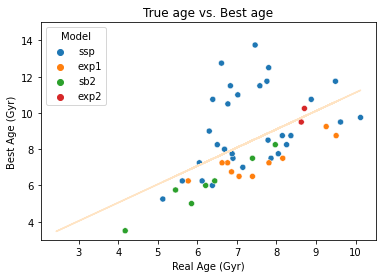

In [14]:
x_data = best_modelDF["Real Age (Gyr)"]
y_data = best_modelDF["Best Age (Gyr)"]

# Define the linear function to fit
def linear_function(x, m, b):
    return m * x + b

# Fit the data to the linear function
params, covariance = curve_fit(linear_function, x_data, y_data)

# Extract the slope (m) and y-intercept (b) from the parameters
m, b = params

# Create a line using the fitted parameters
fit_line = linear_function(x_data, m, b)

sns.scatterplot(data=best_modelDF, x="Real Age (Gyr)", y="Best Age (Gyr)", hue="Model").set_title("True age vs. Best age")
plt.plot(x_data, fit_line, color='bisque', label=f'Fitted Line: y = {m:.2f}x + {b:.2f}')
plt.ylim(3,15)

#plt.savefig('trueage_vs_bestage.png')

## For each Star Formation Rate, plot the k-correction from the models, then compare it to the k-correction you computed in https://github.com/juliarobe/Galaxy_Morphology_Evolution:

First: I need to run the cm evolution code in bc03 on the files to produce the .magnitude_FN1 and .magnitude_FN2 files (which contain both z and the k-correction)

In [15]:
model = ["models/ssp/hr_chabrier_ssp_", "models/exp1/hr_chabrier_exp1_", "models/exp2/hr_chabrier_exp2_", 
         "models/exp3/hr_chabrier_exp3_", "models/sb2/hr_chabrier_sb2_"]

path_to_wsl = r"\\wsl.localhost\Ubuntu\home\jerobe\GALAXEV\bc03\models"

kcorr_rpath = os.path.join(path_to_wsl, "kcorr_r.txt").replace("\\", "/")
kcorr_rfile = open(kcorr_rpath, 'w')

redshift = gals50["z"].values
true_age = gals50["age"].values

for i in range(len(gals50["z"])):
    z = str(redshift[i])
    age = str(true_age[i])
    for mod in range(len(model)):
        mm=model[mod]
        ised_file = "/home/jerobe/GALAXEV/bc03/"+mm+"m162_z_"+str(i)+".ised"
        command_str="$bc03/cm_evolution<<<$'70.0,0.300,0.700\\n"+age+"\\n"+ised_file+"\\n122'"
        #the r-band files will save as a ".magnitude_F122" file
        kcorr_rfile.write(command_str+"\n")
kcorr_rfile.close()

In [16]:
model = ["models/ssp/hr_chabrier_ssp_", "models/exp1/hr_chabrier_exp1_", "models/exp2/hr_chabrier_exp2_", 
         "models/exp3/hr_chabrier_exp3_", "models/sb2/hr_chabrier_sb2_"]

path_to_wsl = r"\\wsl.localhost\Ubuntu\home\jerobe\GALAXEV\bc03\models"

kcorr_gpath = os.path.join(path_to_wsl, "kcorr_g.txt").replace("\\", "/")
kcorr_gfile = open(kcorr_gpath, 'w')

redshift = gals50["z"].values
true_age = gals50["age"].values

for i in range(len(gals50["z"])):
    z = str(redshift[i])
    age = str(true_age[i])
    for mod in range(len(model)):
        mm=model[mod]
        ised_file = "/home/jerobe/GALAXEV/bc03/"+mm+"m162_z_"+str(i)+".ised"
        command_str="$bc03/cm_evolution<<<$'70.0,0.300,0.700\\n"+age+"\\n"+ised_file+"\\n121'"
        #the g-band files will save as a ".magnitude_F121" file
        kcorr_gfile.write(command_str+"\n")
kcorr_gfile.close()

### Now: extract z-values and k-correction values from .magnitude_F121 (g-band) and .magnitude_F122 (r-band), save in dictionary:

In [17]:
#path to models files:
model = [r"\\wsl.localhost\Ubuntu\home\jerobe\GALAXEV\bc03\models\ssp\hr_chabrier_ssp_",
         r"\\wsl.localhost\Ubuntu\home\jerobe\GALAXEV\bc03\models\exp1\hr_chabrier_exp1_",
         r"\\wsl.localhost\Ubuntu\home\jerobe\GALAXEV\bc03\models\exp2\hr_chabrier_exp2_",
         r"\\wsl.localhost\Ubuntu\home\jerobe\GALAXEV\bc03\models\exp3\hr_chabrier_exp3_",
         r"\\wsl.localhost\Ubuntu\home\jerobe\GALAXEV\bc03\models\sb2\hr_chabrier_sb2_"]
model_name = ["ssp","exp1","exp2","exp3","sb2"]
mod_kcorr_r = {}
true_age = gals50["age"].values

for i in range(len(model)):
    mod = model[i]
    name = model_name[i]
    kcorr_rmod = {}
    for j in range(len(gals50['z'])):
        filename = mod + "m162_z_" + str(j) + ".magnitude_F122"
        data = np.genfromtxt(filename, usecols = (0,13))
        redshift = data[:,0]
        kcorr = data[:,1]
        age = true_age[j]
        kcorr_rmod[str(j)] = {'age': age, 'redshift': redshift, 'kcorr': kcorr}
    mod_kcorr_r[name] = kcorr_rmod

In [18]:
#path to models files:
model = [r"\\wsl.localhost\Ubuntu\home\jerobe\GALAXEV\bc03\models\ssp\hr_chabrier_ssp_",
         r"\\wsl.localhost\Ubuntu\home\jerobe\GALAXEV\bc03\models\exp1\hr_chabrier_exp1_",
         r"\\wsl.localhost\Ubuntu\home\jerobe\GALAXEV\bc03\models\exp2\hr_chabrier_exp2_",
         r"\\wsl.localhost\Ubuntu\home\jerobe\GALAXEV\bc03\models\exp3\hr_chabrier_exp3_",
         r"\\wsl.localhost\Ubuntu\home\jerobe\GALAXEV\bc03\models\sb2\hr_chabrier_sb2_"]
model_name = ["ssp","exp1","exp2","exp3","sb2"]
mod_kcorr_g = {}
true_age = gals50["age"].values

for i in range(len(model)):
    mod = model[i]
    name = model_name[i]
    kcorr_gmod = {}
    for j in range(len(gals50['z'])):
        filename = mod + "m162_z_" + str(j) + ".magnitude_F121"
        data = np.genfromtxt(filename, usecols = (0,13))
        redshift = data[:,0]
        kcorr = data[:,1]
        age = true_age[j]
        kcorr_gmod[str(j)] = {'age': age, 'redshift': redshift, 'kcorr': kcorr}
    mod_kcorr_g[name] = kcorr_gmod

### Plotting:

In [19]:
cmap = plt.cm.jet

#linearly normalizing data into a [0.0, 1.0] interval
norm = colors.Normalize(vmin=np.min(gals50["age"]), vmax=np.max(gals50["age"]))

#using the jet colormap and normalization to map the values in the "age" column to corresponding colors
ccmap= cmap(norm(gals50["age"]))
label_arr = gals50["age"].values

### R-band Plots:

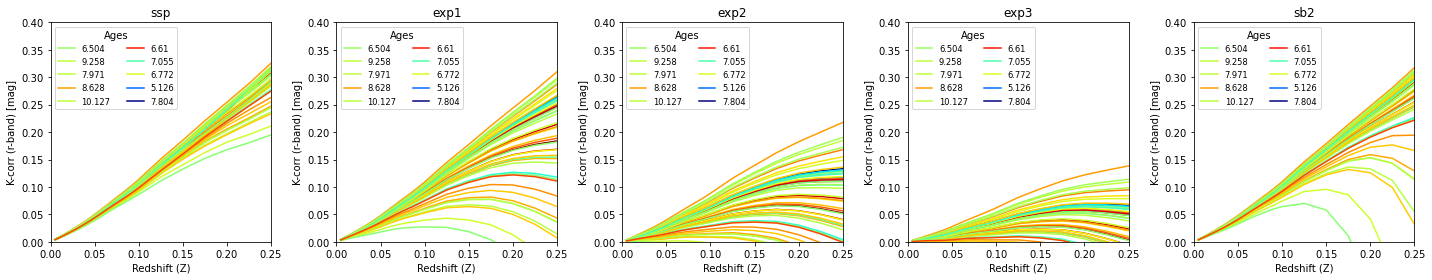

In [20]:
fig = plt.figure(figsize=(20,4))
c = 1
for mod in ["ssp","exp1","exp2","exp3","sb2"]:
    plt.subplot(1,5,c)
    legend_labels = []
    for i in range(50):
        if i%5 == 0:
            label = label_arr[i]
            legend_labels.append(label)
        plt.plot(mod_kcorr_r[mod][str(i)]['redshift'], mod_kcorr_r[mod][str(i)]['kcorr'], color=ccmap[i])
    plt.xlabel("Redshift (Z)")
    plt.ylabel("K-corr (r-band) [mag]")
    plt.xlim(0,0.25)
    plt.ylim(0,0.4)
    plt.title(mod)
    # Add legend with smaller font size and multiple columns
    plt.legend(legend_labels, title='Ages', fontsize='small', loc='upper left', bbox_to_anchor=(0, 1), ncol=2)
    c+=1
    
# Adjust layout to prevent overlap of y-axis labels
plt.tight_layout()
plt.savefig('kcorr_rband.png')

### K-correction computed from ETG's in sample A from https://github.com/juliarobe/Galaxy_Morphology_Evolution: <br>
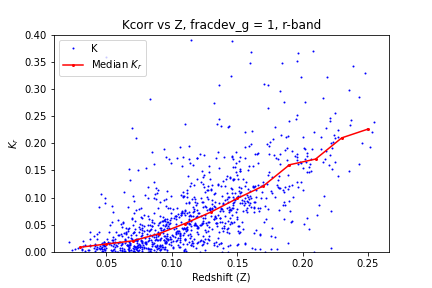

Comparing the k-correction for the various models at different ages to the k-correction in the r-band I computed for sample A, it seems as though a few SFR models (ssp, exp1, exp2) could match the k-correction for sample A at different ages. However, if I were to plot the k-correction for all of the SFR models at the median age, it looks like the model that would match sample A's k-correction in the r-band the closest would be the SSP model. 

### G-band Plots:

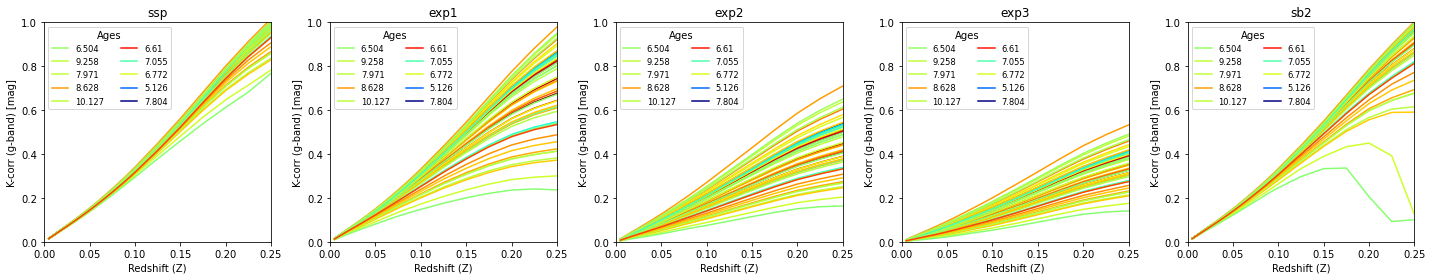

In [21]:
fig = plt.figure(figsize=(20,4))
c = 1
for mod in ["ssp","exp1","exp2","exp3","sb2"]:
    plt.subplot(1,5,c)
    legend_labels = []
    for i in range(50):
        if i%5 == 0:
            label = label_arr[i]
            legend_labels.append(label)
        plt.plot(mod_kcorr_g[mod][str(i)]['redshift'], mod_kcorr_g[mod][str(i)]['kcorr'], color=ccmap[i])
    plt.xlabel("Redshift (Z)")
    plt.ylabel("K-corr (g-band) [mag]")
    plt.xlim(0,0.25)
    plt.ylim(0,1)
    plt.title(mod)
    # Add legend with smaller font size and multiple columns
    plt.legend(legend_labels, title='Ages', fontsize='small', loc='upper left', bbox_to_anchor=(0, 1), ncol=2)
    c+=1
    
# Adjust layout to prevent overlap of y-axis labels
plt.tight_layout()
#plt.savefig('kcorr_gband.png')

**K-correction computed from ETG's in sample A from https://github.com/juliarobe/Galaxy_Morphology_Evolution:** <br>
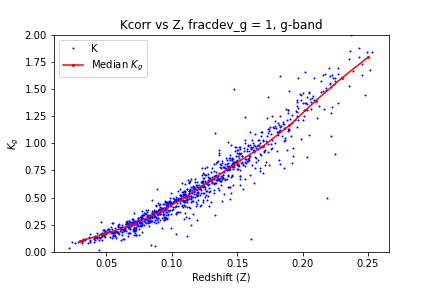

Similarly, comparing the k-correction for the various models at different ages to the k-correction in the g-band I computed for sample A, it seems as though a few SFR models (ssp, exp1, sb2) could match the k-correction for sample A at different ages. However, if I were to plot the k-correction for all of the SFR models at the median age, it looks like the model that would match sample A's k-correction in the g-band the closest would also be the SSP model. 

### Compute the formation time using the stellar mass in gals50:

In [22]:
redshift = Etypes["z"].values
age = Etypes["age"].values

tform_arr, zform_arr = getTimeRedshiftInv(redshift, age)

Etypes["tform"] = tform_arr
Etypes["zform"] = zform_arr

Mr_sun = 4.67

Etypes['L'] = 10**(-0.4*(Etypes['absMr'] - Mr_sun))
Etypes['Mass'] = 10**(Etypes["log($M_*$)"])
Etypes['M/L'] = Etypes['Mass']/Etypes['L']

#### Binning $\frac{M_*}{L}$ and L in bins of $\Delta $tform = 1 Gyr:

In [23]:
round_tform = np.round(Etypes['tform'],0)
tbin = pd.cut(round_tform, bins=np.arange(0,10),labels=np.arange(0,10)[1:])

Etypes['T_bin'] = tbin

In [24]:
# Group by tform bins and calculate statistics for M_star/L and L
result = Etypes.groupby('T_bin').agg({'M/L': 'median', 'L': 'median'}).reset_index()

### Plotting $\frac{M_*}{L}$ versus L in various ways:

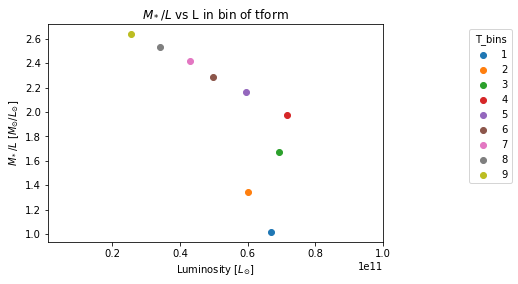

In [25]:
# Plot M_star/L vs. L for each tform bin
for label, group in result.groupby('T_bin'):
    plt.scatter(group['L'], group['M/L'], label=str(label))
    
# Add labels and legend
plt.xlabel('Luminosity [$L_{\odot}$]')
plt.ylabel('$M_*/L$ [$M_{\odot}/L_{\odot}]$')
plt.xlim(1e9,1e11)
plt.legend(title='T_bins', loc='upper right', bbox_to_anchor=(1.4, 1))
plt.title('$M_*/L$ vs L in bin of tform')
#plt.savefig('ml_vs_L_tformbins.png')
plt.show()

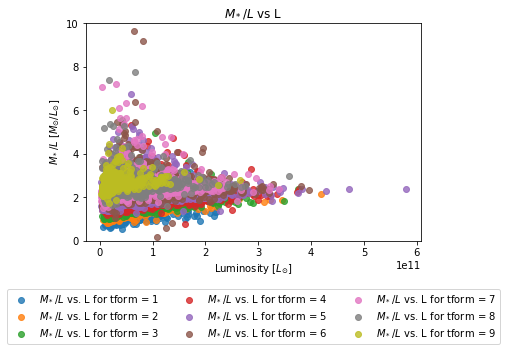

In [26]:
# Group by 'T_bin'
grouped_data = Etypes.groupby('T_bin')

# Plot M_star/L vs. L for each group in each tform bin
for label, group in grouped_data:
    plt.scatter(group['L'], group['M/L'], label=f'$M_*/L$ vs. L for tform = {label}', alpha = 0.8)

# Add labels and legend below the plot
plt.title('$M_*/L$ vs L')
plt.xlabel('Luminosity [$L_{\odot}$]')
plt.ylabel('$M_*/L$ [$M_{\odot}/L_{\odot}]$')
plt.ylim(0,10)
#plt.xlim(1e6,1e12)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3)

#plt.savefig('ml_vs_L_alloneplot.png')

# Show the plot
plt.show()

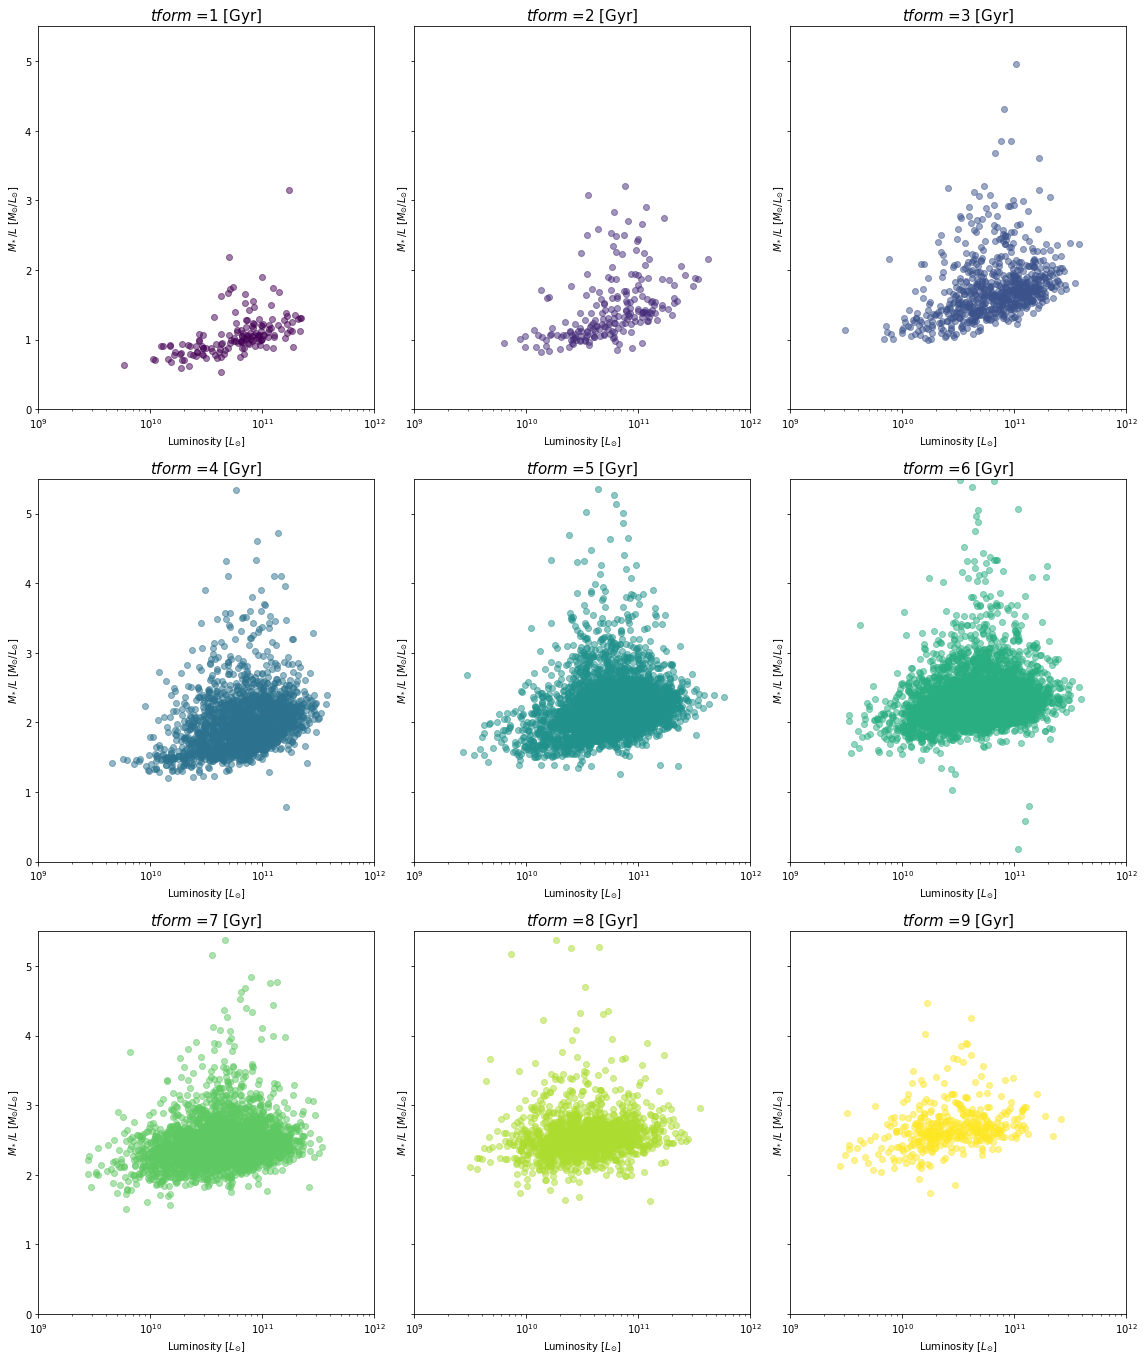

In [27]:
# Get unique T_bin values
unique_bins = Etypes['T_bin'].unique().sort_values().dropna()

# Set up subplots
num_bins = len(unique_bins)
num_rows = 3
num_cols = num_bins // num_rows + (num_bins % num_rows > 0)
fig, axs = plt.subplots(num_rows, num_cols, figsize=(16, 19), sharey=True)

# Flatten axs array for easier indexing
axs = axs.flatten()

cmap = plt.cm.get_cmap('viridis', len(unique_bins))

# Iterate over unique T_bin values and plot on separate subplots
for i, t_bin in enumerate(unique_bins):
    group = Etypes[Etypes['T_bin'] == t_bin]
    ax = axs[i]
    ax.scatter(group['L'], group['M/L'], color=cmap(i),alpha=0.5)
    ax.set(xscale="log",ylim=(0.6e0,6))
    ax.set_xlabel('Luminosity [$L_{\odot}$]')
    ax.set_ylabel('$M_*/L$ [$M_{\odot}/L_{\odot}]$')
    ax.set_title("$tform$ ="+str(t_bin)+" [Gyr]",fontsize=15)
    ax.set_xticks([1e9, 1e10, 1e11, 1e12])
    ax.set_xticklabels(['$10^9$', '$10^{10}$', '$10^{11}$', '$10^{12}$'])
    plt.ylim(0.,5.5)
    plt.xlim(1e9,1e12)

# Remove empty subplots
for j in range(len(unique_bins), len(axs)):
    fig.delaxes(axs[j])

# Adjust layout
plt.tight_layout()


# Show the plot
plt.show()

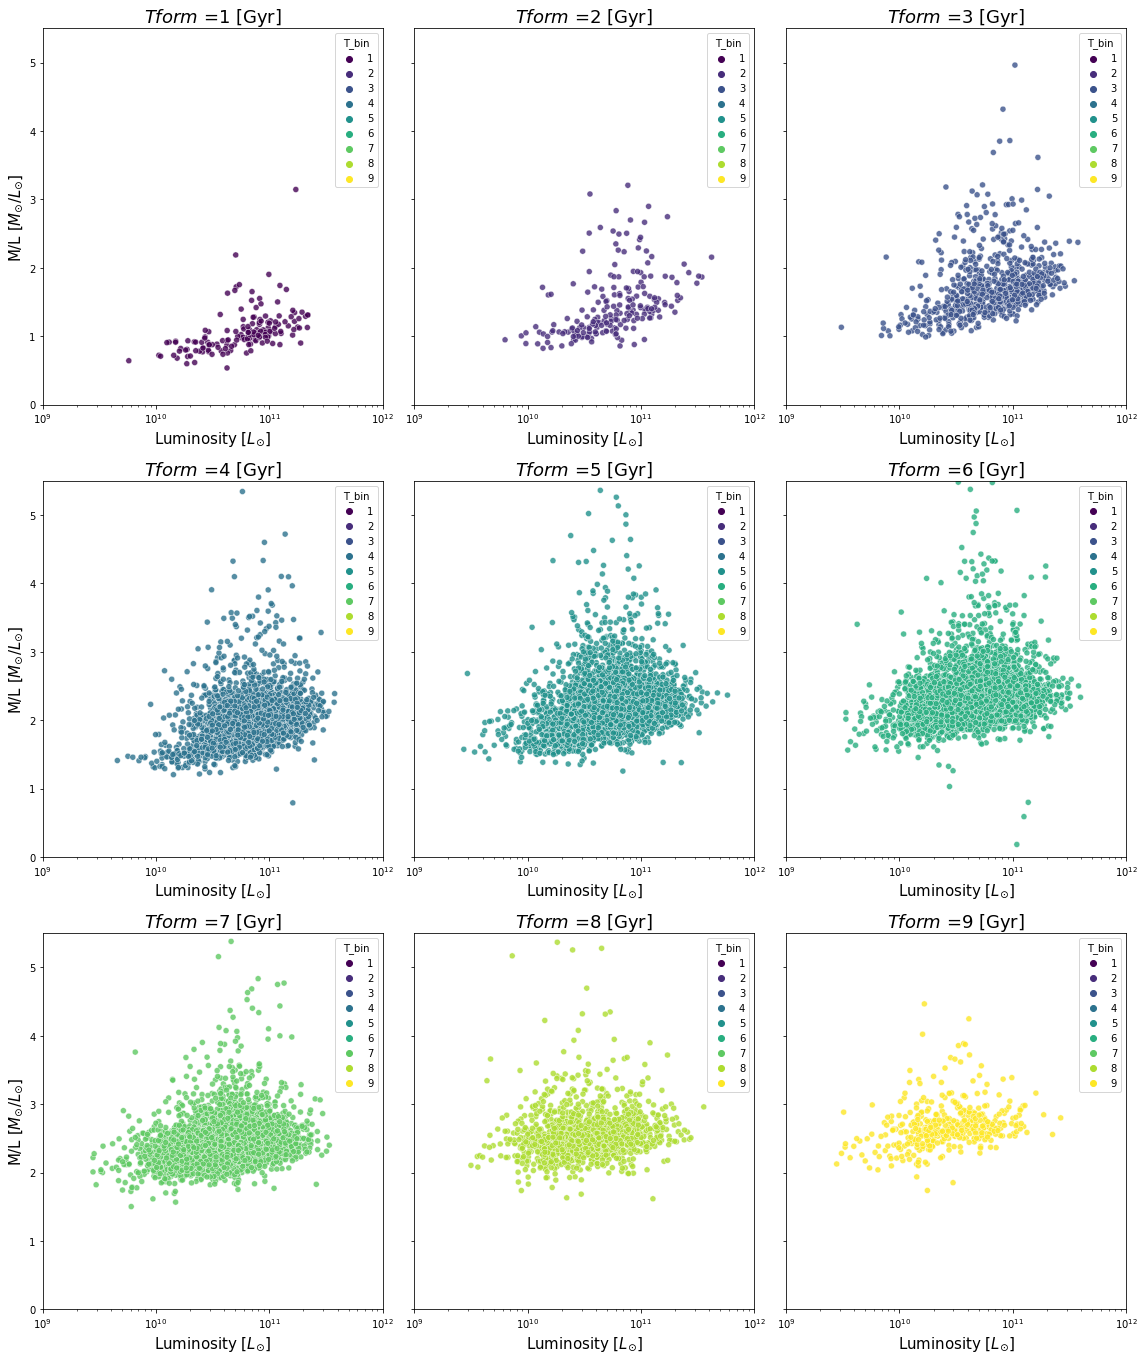

In [28]:
# Get unique T_bin values
unique_bins = Etypes['T_bin'].unique().sort_values().dropna()

# Set up subplots
num_bins = len(unique_bins)
num_rows = 3
num_cols = num_bins // num_rows + (num_bins % num_rows > 0)
fig, axs = plt.subplots(num_rows, num_cols, figsize=(16, 19), sharey=True)

# Flatten axs array for easier indexing
axs = axs.flatten()

num = len(unique_bins)
cmap = plt.cm.get_cmap('viridis', num)

# Create a list of colors from the colormap
colors = [cmap(i) for i in range(num)]

for i, t_bin in enumerate(unique_bins):
    ax = axs[i]
    
    # Filter your DataFrame based on the current T_bin
    group = Etypes[Etypes["T_bin"] == t_bin]
    
    # Scatter plot
    g = sns.scatterplot(data=group, x="L", y="M/L", hue = "T_bin", alpha=0.8, palette=colors, ax=ax)
    
    # Set scaling and labels
    ax.set(xscale="log", ylim=(0.6e0, 6))
    ax.set_xticks([1e9, 1e10, 1e11, 1e12])
    ax.set_xticklabels(['$10^9$', '$10^{10}$', '$10^{11}$', '$10^{12}$'])
    ax.set_xlabel("Luminosity [$L_{\odot}$]", fontsize=15)
    ax.set_ylabel("M/L [$M_{\odot}/L_{\odot}$]", fontsize=15)
    ax.set_title("$Tform$ ="+str(t_bin)+" [Gyr]",fontsize=18)
    
    # Set plot limits
    plt.ylim(0., 5.5)
    plt.xlim(1e9, 1e12)

# Remove empty subplots
for j in range(len(unique_bins), len(axs)):
    fig.delaxes(axs[j])

# Adjust layout
plt.tight_layout()

#plt.savefig('ml_vs_L_tformbin_cluster.png')

# Show the plot
plt.show()

### Computing the residuals of the color-velocity dispersion:

**Step 1: Fit g-r versus log($\sigma$):**

In [29]:
x_data = Etypes["log($\sigma$)"]
y_data = Etypes["color_gmr"]

# Define the linear function to fit
def linear_function(x, m, b):
    return m * x + b

# Fit the data to the linear function (uses non-linear least squares to fit a function to data)
params, covariance = curve_fit(linear_function, x_data, y_data)

# Extract the slope (m) and y-intercept (b) from the parameters
m, b = params

# Create a line using the fitted parameters
fit = linear_function(x_data, m, b)
Etypes['vdisp_res'] = y_data - fit

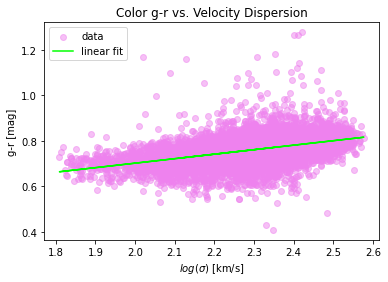

In [30]:
plt.scatter(x_data, y_data, label = 'data', alpha = 0.5, color = 'violet')
plt.plot(x_data, fit, label = 'linear fit', color = 'lime')
plt.xlabel('$log(\sigma$) [km/s]')
plt.ylabel('g-r [mag]')
plt.title("Color g-r vs. Velocity Dispersion")
plt.savefig('colore_vs_vdisp.png')
plt.legend()

**Step 2: Binning by absolute magnitude:**

In [31]:
Etypes['absMr_bin'] = np.round(Etypes["absMr"],0)

**Plotting residual versus age in bins of absolute magnitude:**

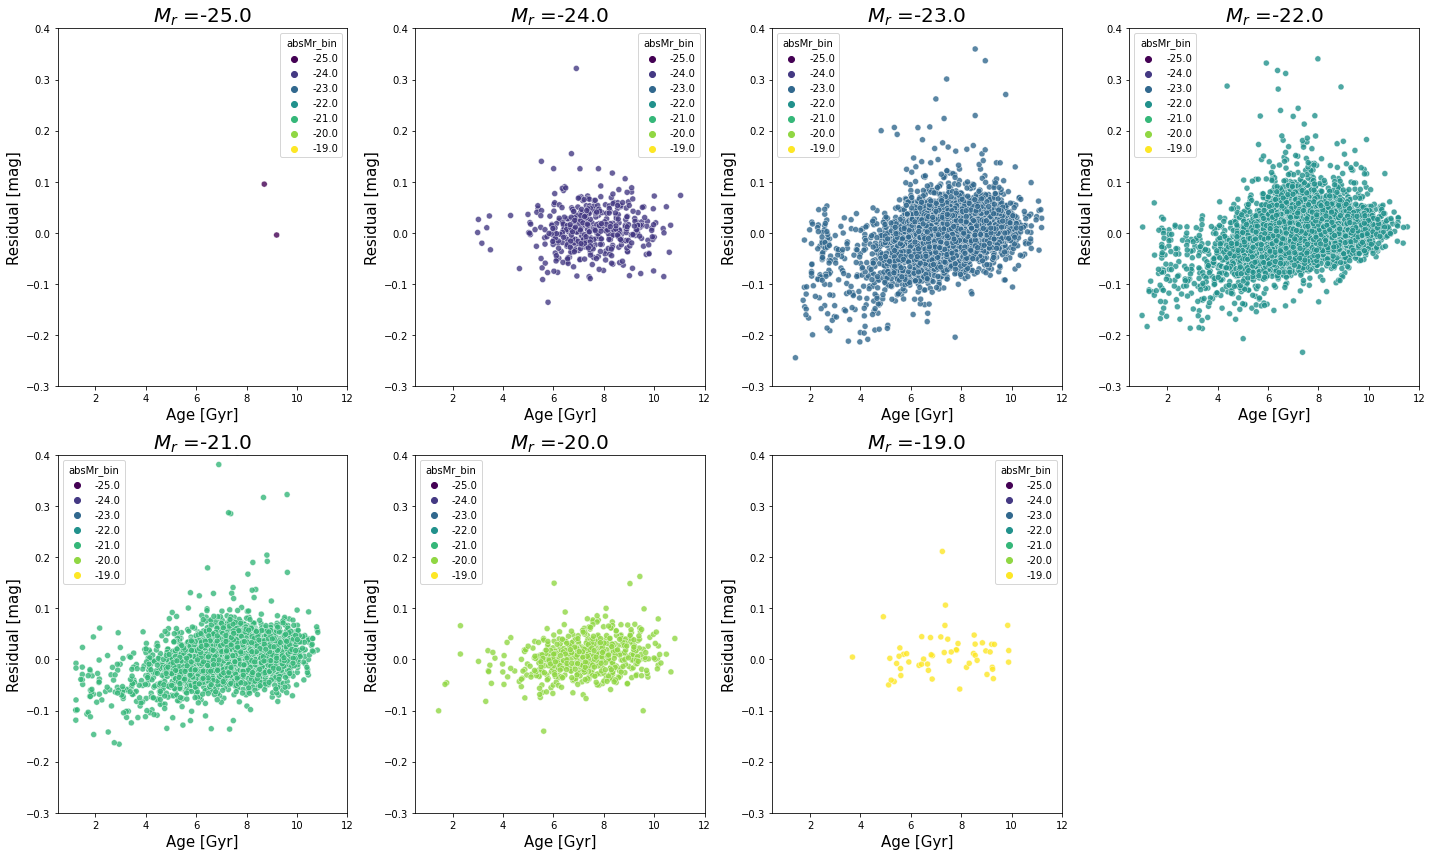

In [32]:
unique_bins = sorted(Etypes['absMr_bin'].unique())

num = len(unique_bins)
cmap = plt.cm.get_cmap('viridis', num)

# Create a list of colors from the colormap
colors = [cmap(i) for i in range(num)]

c=1
fig = plt.figure(figsize=(20, 12))
for m in unique_bins: #[-19.0,-20.0,-21.0,-22.0,-23.0,-24.0,-25.0]:
    plt.subplot(2,4,c)
    group = Etypes[Etypes["absMr_bin"] == m]
    g=sns.scatterplot(data=group,x="age",y="vdisp_res", hue = "absMr_bin", alpha=0.8, palette=colors, hue_order=unique_bins)
    g.set(ylim=(-0.4,0.4))
    g.set_xlabel("Age [Gyr]",fontsize=15)
    g.set_ylabel("Residual [mag]",fontsize=15)
    g.set_title("$M_{r}$ ="+str(m),fontsize = 20)
    c+=1   
    plt.xlim(0.5,12)
    plt.ylim(-0.3,0.4)
    
plt.savefig('resid_vs_age_magbins.png')
plt.tight_layout()